In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import gensim
from scipy import stats
from tqdm import tqdm
import pickle
from scipy import spatial

In [2]:
def get_scores(path):
    with open(path, 'r') as file:
        i = 1
        scores = []
        for line in file:
            if i%2 == 0:
                scores.append(float(line[1:-1]))
            i += 1
    return scores

neg_scores = np.absolute(np.array(get_scores('saved/node2vec_negsim128.txt')))
pos_scores = np.absolute(np.array(get_scores('saved/node2vec_possim128.txt')))
scores = {'pred' : neg_scores.tolist(), 'actual' : np.zeros(len(neg_scores)).tolist()}
scores['pred'].extend(pos_scores.tolist())
scores['actual'].extend(np.ones(len(pos_scores)).tolist())

FileNotFoundError: [Errno 2] No such file or directory: 'saved/node2vec_negsim128.txt'

In [3]:
df = pd.DataFrame(scores)
df.head()

,pred,actual
0,0.365787,0.0
1,0.587276,0.0
2,0.271562,0.0
3,0.063177,0.0
4,0.072655,0.0


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


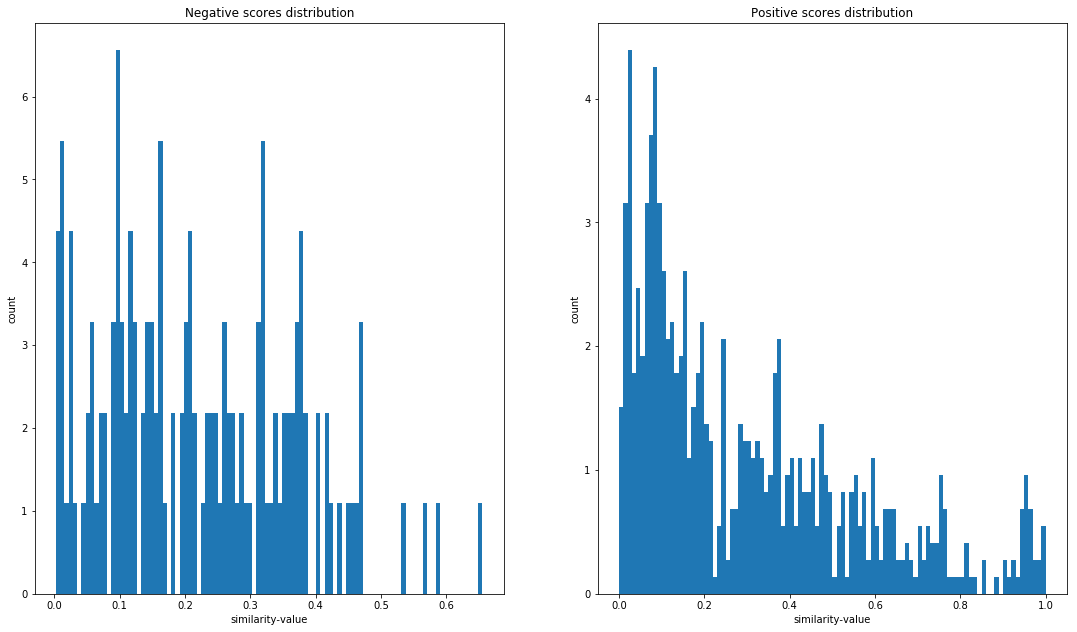

Negative Similarity
Total cases = 140
Max Similarity = 0.6555617
Min Similarity = 0.0022817068
Average Similarity = 0.22013131046357146

Positive Similarity
Total cases = 729
Max Similarity = 1.0
Min Similarity = 0.00022356026
Average Similarity = 0.2962184627283402


In [4]:
fig, axs = plt.subplots(1, 2, constrained_layout=False)
fig.set_size_inches(18.5, 10.5)
axs[0].hist(neg_scores, normed=True, bins=100)
axs[0].set_title('Negative scores distribution')
axs[0].set_ylabel('count')
axs[0].set_xlabel('similarity-value')

axs[1].hist(pos_scores, normed=True, bins=100)
axs[1].set_title('Positive scores distribution')
axs[1].set_ylabel('count')
axs[1].set_xlabel('similarity-value')
plt.show()

print('Negative Similarity')
print('Total cases = {}'.format(len(neg_scores)))
print('Max Similarity = {}'.format(np.max(neg_scores)))
print('Min Similarity = {}'.format(np.min(neg_scores)))
print('Average Similarity = {}'.format(np.mean(neg_scores)))


print('\nPositive Similarity')
print('Total cases = {}'.format(len(pos_scores)))
print('Max Similarity = {}'.format(np.max(pos_scores)))
print('Min Similarity = {}'.format(np.min(pos_scores)))
print('Average Similarity = {}'.format(np.mean(pos_scores)))

Area under curve = 0.5496766607877719


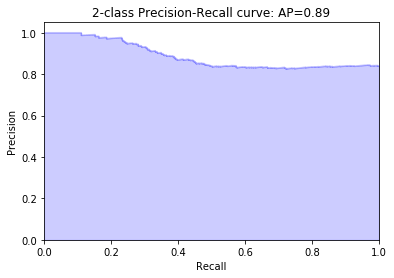

In [5]:
average_precision = average_precision_score(df['actual'], df['pred'])
precision, recall, thresh = precision_recall_curve(df['actual'], df['pred'])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
print('Area under curve = {}'.format(roc_auc_score(df['actual'], df['pred'])))


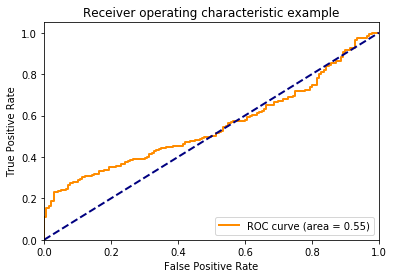

In [6]:
from sklearn.metrics import roc_curve, auc
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(df['actual'], df['pred'])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(df['actual'].ravel(), df['pred'].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


In [35]:
def scores(modelp, path, meta):
    ann = []
    text = []
    net = []
    if meta != 1:
        model = gensim.models.Word2Vec.load(modelp)
    foo = open('saved/similarity_scores_test.txt', 'w')
    with open(path) as file:
        for line in file:
            temp = line.split()
            case1, case2 = temp[0], temp[1]
            try:
                if meta == 1:
                    sim = 1 - spatial.distance.cosine(cases[case1], cases[case2])
                else:
                    sim = model.wv.similarity(case1, case2)
                net.append(sim)
                ann.append(float(temp[2]))
                text.append(float(temp[3]))
            except:
                continue
            outline = line[:-1] + ' ' + str(sim) +'\n'
            foo.write(outline)
    foo.close()
    print('-----Correlations-----')
    print('Text - Annotated = {}'.format(np.corrcoef(text, ann)[0][1]))
    print('Text - Network = {}'.format(np.corrcoef(text, net)[0][1]))
    print('Network - Annotated = {}'.format(np.corrcoef(net, ann)[0][1]))
    print('-----T-Test-----')
    print('Text - Network = {}'.format(stats.ttest_ind(text, net, equal_var = False)))
    print('Variance of Text scores = {}'.format(np.var(text)))
    print('Variance of net scores = {}'.format(np.var(net)))
    


In [6]:
print('1 When trained on complete network')
#scores('saved/node2vec.model128', 'sample/test_scores.txt', 0)
print('\n---------------+---------------\n')
print('2 When trained only on test-network')
scores('saved/smallnode2vec.model128', 'sample/test_scores.txt', 0)

1 When trained on complete network

---------------+---------------

2 When trained only on test-network
-----Correlations-----
Text - Annotated = 0.6799924765477332
Text - Network = 0.3941266951916733
Network - Annotated = 0.18881296597618782
-----T-Test-----
Text - Network = Ttest_indResult(statistic=3.110553216449797, pvalue=0.002548539768314992)
Variance of Text scores = 0.03752368100189036
Variance of net scores = 0.06407313048839569


/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [37]:
def read_meta_feat(path, ca):
    cases = {}
    with open(path, 'rb') as file:
        i = 0
        for line in tqdm(file):
            if i <= 1:
                i += 1
                continue
            i += 1
            temp = line.decode()
            temp = temp.split()
            try:
                ca[temp[0]]
                cases[temp[0]] = [float(j) for j in temp[1:]]
            except KeyError as error:
                continue
    print('Cases = {}'.format(len(cases)))
    return cases

In [38]:
path = '/Users/deepthought/code/docsim/saved/metapath2vec_embeddings.txt'
small_path = '/Users/deepthought/code/docsim/saved/small_metapath2vec_embeddings.txt'
with open('saved/smallcase_act_sec_dict.pickle', 'rb') as file:
        ca = pickle.load(file)
cases = read_meta_feat(path = small_path, ca = ca)

111it [00:00, 14283.41it/s]

Cases = 59


In [39]:
print('1 When trained on complete network')
scores('saved/node2vec.model128', 'sample/test_scores.txt', 1)
print('\n---------------+---------------\n')
print('2 When trained only on test-network')
scores('saved/smallnode2vec.model128', 'sample/test_scores.txt', 1)

1 When trained on complete network
-----Correlations-----
Text - Annotated = 0.6799924765477332
Text - Network = 0.14757388567596638
Network - Annotated = -0.040961480861899525
-----T-Test-----
Text - Network = Ttest_indResult(statistic=-15.018555494237768, pvalue=2.963193618417006e-25)
Variance of Text scores = 0.03752368100189036
Variance of net scores = 0.019653564643311746

---------------+---------------

2 When trained only on test-network
-----Correlations-----
Text - Annotated = 0.6799924765477332
Text - Network = 0.14757388567596638
Network - Annotated = -0.040961480861899525
-----T-Test-----
Text - Network = Ttest_indResult(statistic=-15.018555494237768, pvalue=2.963193618417006e-25)
Variance of Text scores = 0.03752368100189036
Variance of net scores = 0.019653564643311746
